This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/experiments


In [7]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/10242023_v3.3/results"

# Directory to save figures
PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [8]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [9]:
folders = ["baseline"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.37276547126919934]
values [0.3690128721010544]
values [0.36343580301758005]
values [0.36368832803181833]
values [0.3623974678556566]
Overall quality when there is no bots: 0.37


# Shuffle 
Effects of network structure on Quality

In [10]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.367479,0.378244,0.371974,0.373080,0.365529,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.360379,0.355953,0.359285,0.371365,0.359991,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.362148,0.378018,0.369720,0.367033,0.372961,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.365636,0.372428,0.363280,0.376707,0.367864,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.358100,0.367630,0.368649,0.356654,0.366823,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.366909,0.377385,0.367314,0.373860,0.371301,community_shuffle__None2.json,community


In [11]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [12]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
4,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.358965,0.355223,0.353127,0.354641,0.360759,None


In [13]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.367479,0.378244,0.371974,0.373080,0.365529,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.360379,0.355953,0.359285,0.371365,0.359991,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.362148,0.378018,0.369720,0.367033,0.372961,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.365636,0.372428,0.363280,0.376707,0.367864,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.358100,0.367630,0.368649,0.356654,0.366823,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.366909,0.377385,0.367314,0.373860,0.371301,community_shuffle__None2.json,community


In [14]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [15]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.358965,...,0.354641,0.360759,None,NaN,0.980083,0.969867,0.964144,0.968276,0.984981,0
1,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.367479,...,0.373080,0.365529,community,community_shuffle__None3.json,1.003329,1.032719,1.015600,1.018620,0.998003,1
2,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.360379,...,0.371365,0.359991,hub,hub_shuffle__None3.json,0.983944,0.971860,0.980956,1.013939,0.982883,2
3,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.362148,...,0.367033,0.372961,all,all_shuffle__None3.json,0.988773,1.032103,1.009447,1.002112,1.018296,3
4,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.365636,...,0.376707,0.367864,all,all_shuffle__None2.json,0.998295,1.016841,0.991863,1.028525,1.004380,4
5,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.358100,...,0.356654,0.366823,hub,hub_shuffle__None2.json,0.977720,1.003740,1.006523,0.973772,1.001538,5
6,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.366909,...,0.373860,0.371301,community,community_shuffle__None2.json,1.001771,1.030375,1.002877,1.020749,1.013764,6


In [16]:
results

,id,run_no,theta,quality_1,quality_4,file_name,quality_3,graph_gml,beta,mu,shuffle,rho,gamma,epsilon,phi,quality_2,quality_0,targeting_criterion,relative_quality_
0,0,0,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.980083
1,1,0,1,0.378244,0.365529,community_shuffle__None3.json,0.373080,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.10,0.0001,0.0,0.371974,0.367479,none,1.003329
2,2,0,1,0.355953,0.359991,hub_shuffle__None3.json,0.371365,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.10,0.0001,0.0,0.359285,0.360379,none,0.983944
3,3,0,1,0.378018,0.372961,all_shuffle__None3.json,0.367033,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.10,0.0001,0.0,0.369720,0.362148,none,0.988773
4,4,0,1,0.372428,0.367864,all_shuffle__None2.json,0.376707,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.01,0.0001,0.0,0.363280,0.365636,none,0.998295
5,5,0,1,0.367630,0.366823,hub_shuffle__None2.json,0.356654,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.01,0.0001,0.0,0.368649,0.358100,none,0.977720
6,6,0,1,0.377385,0.371301,community_shuffle__None2.json,0.373860,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.01,0.0001,0.0,0.367314,0.366909,none,1.001771
7,0,1,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.969867
8,1,1,1,0.378244,0.365529,community_shuffle__None3.json,0.373080,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.10,0.0001,0.0,0.371974,0.367479,none,1.032719
9,2,1,1,0.355953,0.359991,hub_shuffle__None3.json,0.371365,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.10,0.0001,0.0,0.359285,0.360379,none,0.971860


Plot data for default values $\gamma=0.01$

In [17]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,theta,quality_1,quality_4,file_name,quality_3,graph_gml,beta,mu,shuffle,rho,gamma,epsilon,phi,quality_2,quality_0,targeting_criterion,relative_quality_
0,0,0,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.980083
4,4,0,1,0.372428,0.367864,all_shuffle__None2.json,0.376707,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.01,0.0001,0.0,0.363280,0.365636,none,0.998295
5,5,0,1,0.367630,0.366823,hub_shuffle__None2.json,0.356654,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.01,0.0001,0.0,0.368649,0.358100,none,0.977720
6,6,0,1,0.377385,0.371301,community_shuffle__None2.json,0.373860,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.01,0.0001,0.0,0.367314,0.366909,none,1.001771
7,0,1,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.969867


In [18]:
# !pip install statannotations

In [19]:
plot_data

,id,run_no,theta,quality_1,quality_4,file_name,quality_3,graph_gml,beta,mu,shuffle,rho,gamma,epsilon,phi,quality_2,quality_0,targeting_criterion,relative_quality_
0,0,0,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.980083
4,4,0,1,0.372428,0.367864,all_shuffle__None2.json,0.376707,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.01,0.0001,0.0,0.363280,0.365636,none,0.998295
5,5,0,1,0.367630,0.366823,hub_shuffle__None2.json,0.356654,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.01,0.0001,0.0,0.368649,0.358100,none,0.977720
6,6,0,1,0.377385,0.371301,community_shuffle__None2.json,0.373860,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.01,0.0001,0.0,0.367314,0.366909,none,1.001771
7,0,1,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.969867
11,4,1,1,0.372428,0.367864,all_shuffle__None2.json,0.376707,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.01,0.0001,0.0,0.363280,0.365636,none,1.016841
12,5,1,1,0.367630,0.366823,hub_shuffle__None2.json,0.356654,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,hub,0.8,0.01,0.0001,0.0,0.368649,0.358100,none,1.003740
13,6,1,1,0.377385,0.371301,community_shuffle__None2.json,0.373860,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,community,0.8,0.01,0.0001,0.0,0.367314,0.366909,none,1.030375
14,0,2,1,0.355223,0.360759,NaN,0.354641,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,None,0.8,0.01,0.0001,0.0,0.353127,0.358965,none,0.964144
18,4,2,1,0.372428,0.367864,all_shuffle__None2.json,0.376707,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.05,0.5,all,0.8,0.01,0.0001,0.0,0.363280,0.365636,none,0.991863


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:4.424e-04 t=6.061e+00
hubs vs. communities: Welch's t-test independent samples, P_val:4.464e-02 t=-2.405e+00
random vs. hubs: Welch's t-test independent samples, P_val:1.490e-01 t=1.597e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:3.332e-03 t=4.512e+00


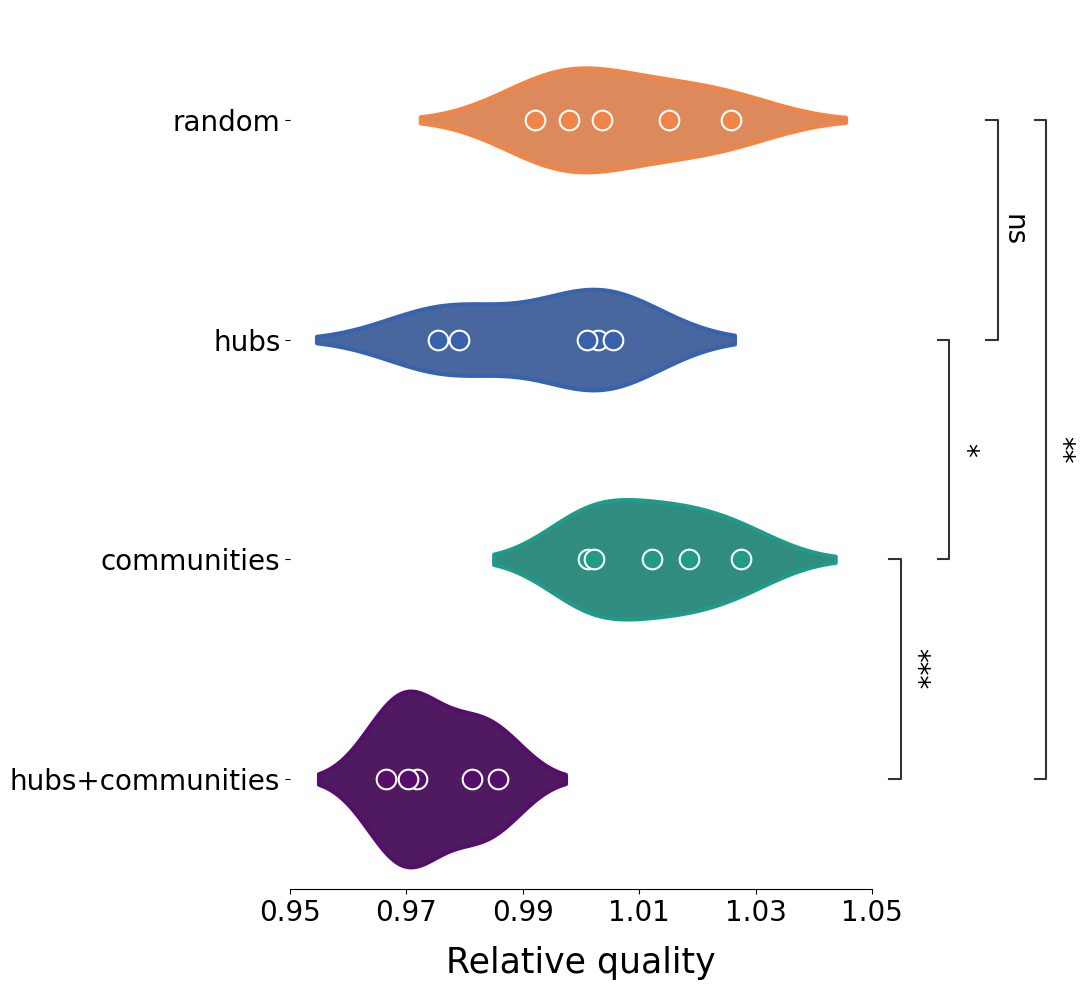

In [20]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [21]:
folders = ["vary_alpha"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,theta,relative_quality_3,alpha,relative_quality_4,relative_quality_0,graph_gml,relative_quality_1,relative_quality_2,beta,mu,rho,gamma,epsilon,phi,targeting_criterion,quality_
1,1,0,1,0.989093,4,0.938026,0.989587,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.935725,1.023437,0,0.5,0.8,0,0.0001,0,none,0.362446
7,1,1,1,0.989093,4,0.938026,0.989587,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.935725,1.023437,0,0.5,0.8,0,0.0001,0,none,0.342719
19,1,3,1,0.989093,4,0.938026,0.989587,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.935725,1.023437,0,0.5,0.8,0,0.0001,0,none,0.362265
25,1,4,1,0.989093,4,0.938026,0.989587,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.935725,1.023437,0,0.5,0.8,0,0.0001,0,none,0.343561
13,1,2,1,0.989093,4,0.938026,0.989587,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0.935725,1.023437,0,0.5,0.8,0,0.0001,0,none,0.374844


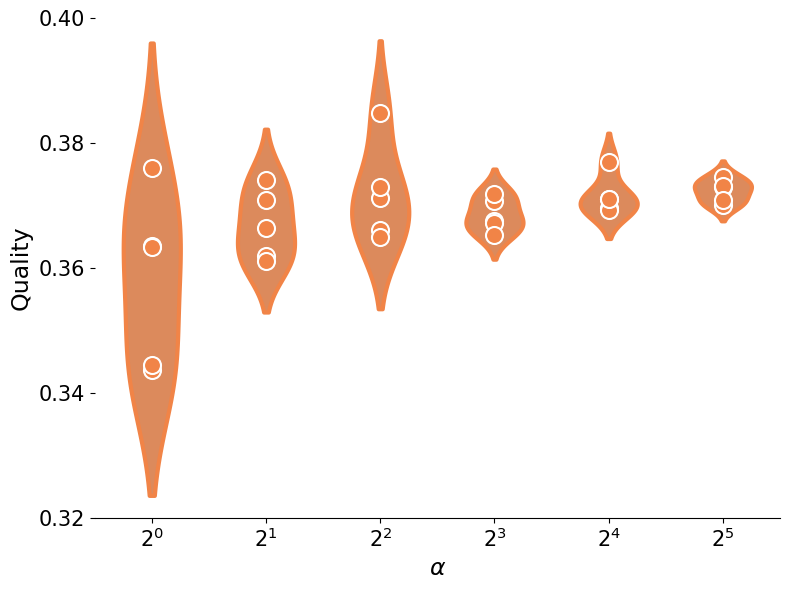

In [22]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [23]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,theta,alpha,graph_gml,beta,mu,rho,gamma,epsilon,phi,targeting_criterion,quality_
3,3,0,1,15,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.1,0.8,0,0.0001,0,none,0.528756
8,3,1,1,15,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.1,0.8,0,0.0001,0,none,0.518575
18,3,3,1,15,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.1,0.8,0,0.0001,0,none,0.534288
23,3,4,1,15,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.1,0.8,0,0.0001,0,none,0.523430
13,3,2,1,15,/N/project/simsom/simsom_v3/v3.3_10222023/data...,0,0.1,0.8,0,0.0001,0,none,0.533035


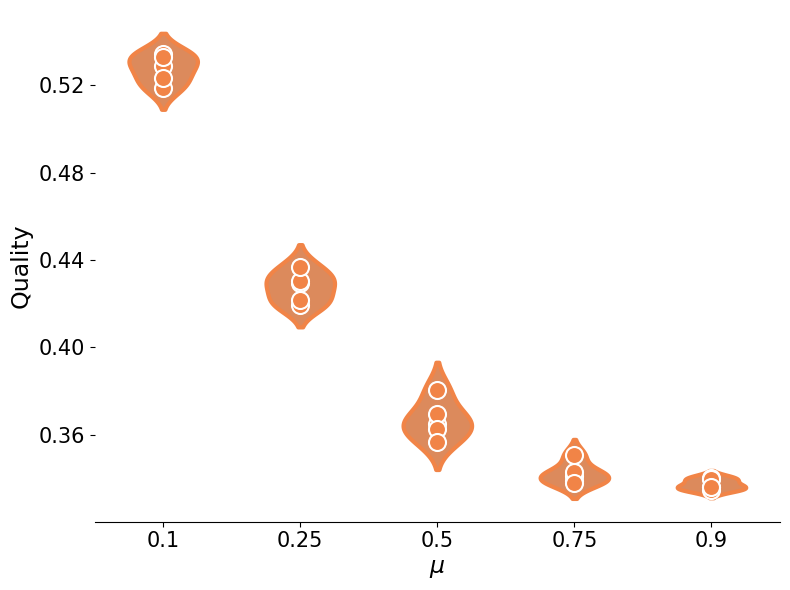

In [24]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [25]:
data = read_data(RES_DIR, folders=["vary_thetaphi_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# thetaphi

### Phigamma

In [31]:
data = read_data(RES_DIR, folders=["vary_phigamma"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

### Thetagamma

In [32]:
data = read_data(RES_DIR, folders=["vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

## Single param plots
Subset data (only plot default values for each panel)

In [43]:
# VARYING GAMMA
vary_gamma = thetagamma
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = phigamma
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = [0.1 * i for i in vary_phi["phi"]]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = thetaphi
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9585209543863158, 0.9626466528182409, 1.0038922721698726, 0.9847207406868576, 1.0407358985434139]
values [1.0132739099499581, 1.00497564596239, 1.0027249261239708, 0.9699625207993932, 1.0117886092527917]
values [0.9413012677290233, 0.9600632347656913, 0.9693551387781012, 0.9588088488473958, 0.9540244136004736]
values [0.9670346182439491, 0.9406715739185322, 0.9749907233984545, 0.9833940858945921, 0.96528957174787]
values [0.9829953947819678, 0.9586420981948873, 0.97706427787663, 0.9511691266829987, 0.9914516414285198, 0.7339224437646176, 0.43104589769437485, 0.020933373984855508]
values [0.964091995467999, 0.9589909814488601, 0.953206476773735, 0.9307320768899559, 0.9496803934126711, 0.7170829517864381, 0.42358298238779896, 0.015853421676472856]
values [1.0034516687139377, 0.9657558210094647, 0.9752919963300262, 0.9558179495377067, 0.9706719856307026, 0.7356579950067379, 0.4314269658884288, 0.022198571779653897]
values [0.9835538377967619, 0.9576333790220622, 0.94136426209062

In [44]:
vary_gamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_4,alpha,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.351068,...,0.381180,15,0.958521,0.962647,1.003892,0.984721,1.040736,0.990103,0.033668,0.041804
1,1,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.371122,...,0.370578,15,1.013274,1.004976,1.002725,0.969963,1.011789,1.000545,0.017664,0.021933
2,1,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.344761,...,0.349421,15,0.941301,0.960063,0.969355,0.958809,0.954024,0.956711,0.010249,0.012726
3,1,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/v3.3_10222023/data...,none,0.354186,...,0.353547,15,0.967035,0.940672,0.974991,0.983394,0.965290,0.966276,0.016016,0.019887


In [48]:
vary_gamma.graph_gml.values

array(['/N/project/simsom/simsom_v3/v3.3_10222023/data/vary_network/network_10.gml',
       '/N/project/simsom/simsom_v3/v3.3_10222023/data/vary_network/network_00.gml',
       '/N/project/simsom/simsom_v3/v3.3_10222023/data/vary_network/network_30.gml',
       '/N/project/simsom/simsom_v3/v3.3_10222023/data/vary_network/network_20.gml'],
      dtype=object)

### Plot

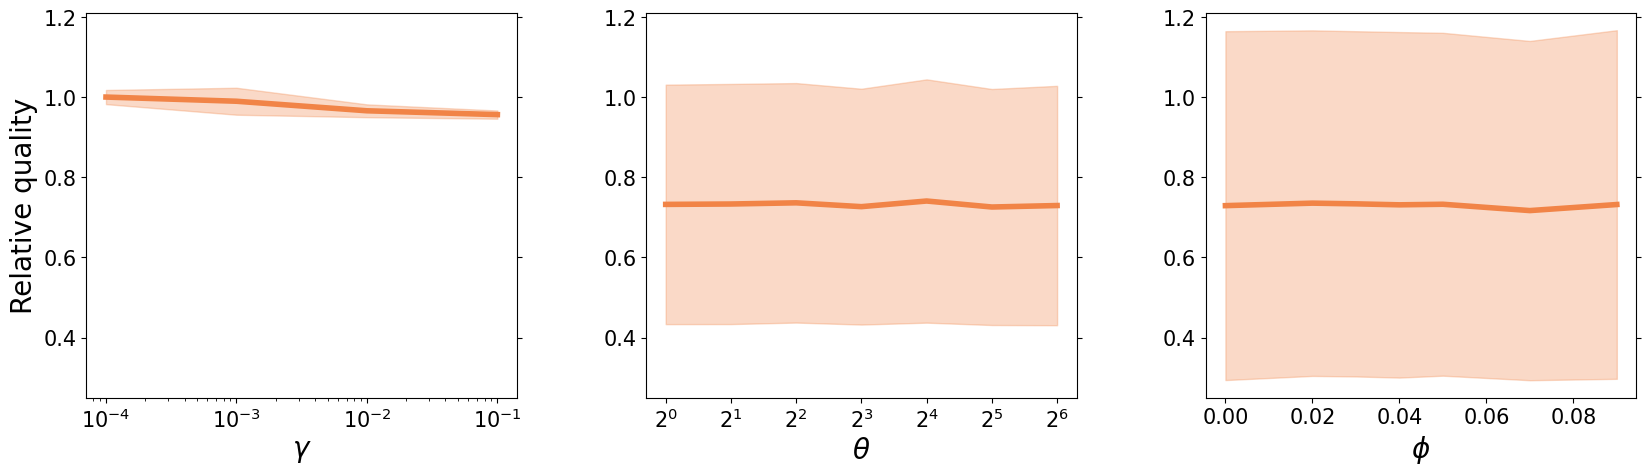

In [45]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [ ]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

values [0.9547928310665047, 0.9629197231077932, 0.9486021666137546, 0.9474791752559338, 0.9556779066726369]
values [0.9559682343472427, 0.9601528365112426, 0.9551635024812533, 0.9764452106008825, 0.9706204659481541]
values [0.9579143509186935, 0.9497869998539423, 0.965170427807803, 0.9474870698684774, 0.9902815459889203]
values [1.1028433845550112, 1.0595799638258043, 1.1343029534979365, 1.1177956588426956, 1.102137009237106]
values [0.9388453454256513, 0.9473322045624979, 0.9721101014799725, 0.9747198817671334, 0.9370863199886111]
values [0.9465492995384538, 0.9637533749737364, 0.9277206253177721, 0.9519304939532836, 0.9618467026450734]
values [1.113524885303397, 1.110865176870156, 1.0829980263221806, 1.1439692068491887, 1.0828185425228596]
values [0.9756967096689296, 0.951058988410883, 0.9610120035948804, 0.972605585022307, 0.9493946475595333]
values [0.9264696459372597, 0.9465559479028942, 0.998667150782, 0.9541657857556979, 0.9496243224231677]
values [0.9590354702061796, 0.96179494

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,1.116303,NaN,NaN,0.959412,0.951230,NaN,1.068563,1.075600,0.958905,0.951971,0.964349
1,2,0.969082,NaN,0.960719,0.969847,0.953894,0.959824,0.952277,0.963701,0.961255,0.955305,1.072303
2,4,0.973421,0.962128,0.959383,0.957024,1.089852,1.085825,NaN,0.958561,0.967155,0.955219,0.955057
3,8,1.119336,NaN,NaN,0.955539,0.964443,0.967131,0.957267,0.961954,NaN,1.067244,0.961156
4,16,NaN,1.106835,1.101786,0.950360,NaN,NaN,0.955097,NaN,NaN,1.061681,0.961578


In [ ]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(7, 11)

### Data: Thetagamma matrix

In [ ]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

values [1.165681577778353, 1.144048156805563, 1.135864026671273, 1.146087857176182, 1.1531388815700103]
values [0.9722897036289985, 0.996004762043203, 0.9522789370350839, 0.9547815549079923, 0.9575546648713732]
values [1.0272683074376592, 0.9961507778262073, 0.9910466644348989, 0.986425970843769, 0.9939637902662615]
values [0.9889448453234225, 0.9552975333827491, 1.0079406723012811, 0.9731068833639701, 0.9876882547028729]
values [0.997081680740486, 1.0481647671113905, 1.007456588778588, 1.0172405584867086, 0.9940091077166053]
values [1.154311911921117, 1.1484373213558436, 1.15994157998708, 1.1664899568731089, 1.1809419118741127]
values [0.977541319510605, 1.0065886339350965, 1.0070728506985687, 1.0069826437124014, 1.0252247849428637]
values [1.0087267103839765, 1.0045222810398766, 1.0137467708780725, 0.9896003594147331, 1.008477077431784]
values [0.9892837618401017, 0.9784262712337771, 0.9812323971929902, 0.9656629838028744, 0.9854701547466754]
values [1.1398753234317538, 1.17649121386

gamma,theta,0.0001,0.001,0.01,0.1
0,1,1.004195,1.152215,1.122674,0.968820
1,2,0.992814,NaN,1.123322,0.970966
2,4,1.010524,1.148964,0.958839,0.989267
3,8,1.012791,0.980015,0.966582,0.967646
4,16,1.005015,0.982596,0.971375,NaN


In [ ]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [ ]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

values [1.010330099524965]
values [1.1173960149894382]
values [1.1907082339048523]
values [1.3393499083571392]
values [1.136536395679729]
values [1.02926176454905]
values [1.1270456058177412]
values [0.9517124734807829]
values [1.336449279507264]
values [1.10277243847338]
values [1.3071337755292376]
values [0.9802999973755993]
values [0.9954955897332963]
values [0.989575421475126]
values [1.1521887760860918]
values [1.1536818762450967]
values [1.1149606456023513]
values [1.088597499498593]
values [1.157117496178852]
values [0.9821933415798618]
values [0.9480491524322359]
values [1.3267565518394195]
values [1.0911306919118626]
values [1.1222733929005058]
values [0.9711928791126712]
values [0.9478082421280872]
values [1.3046859374621749]
values [1.0520359360462261]
values [0.9948753087295319]
values [1.1544176267126918]
values [1.1445753238590153]
values [0.9549742416718101]
values [0.9907057517149463]
values [1.2215694110526916]
values [0.9527077351976787]
values [0.9598009966842883]
va

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,1.304686,1.153682,1.025218,0.959801
1,0.1,1.303416,1.221569,1.088597,1.052036
2,0.2,0.990706,1.010330,1.154418,1.091131
3,0.3,1.336449,1.152189,1.117396,0.938697
4,0.4,0.995496,1.127046,1.122152,1.029262


In [ ]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

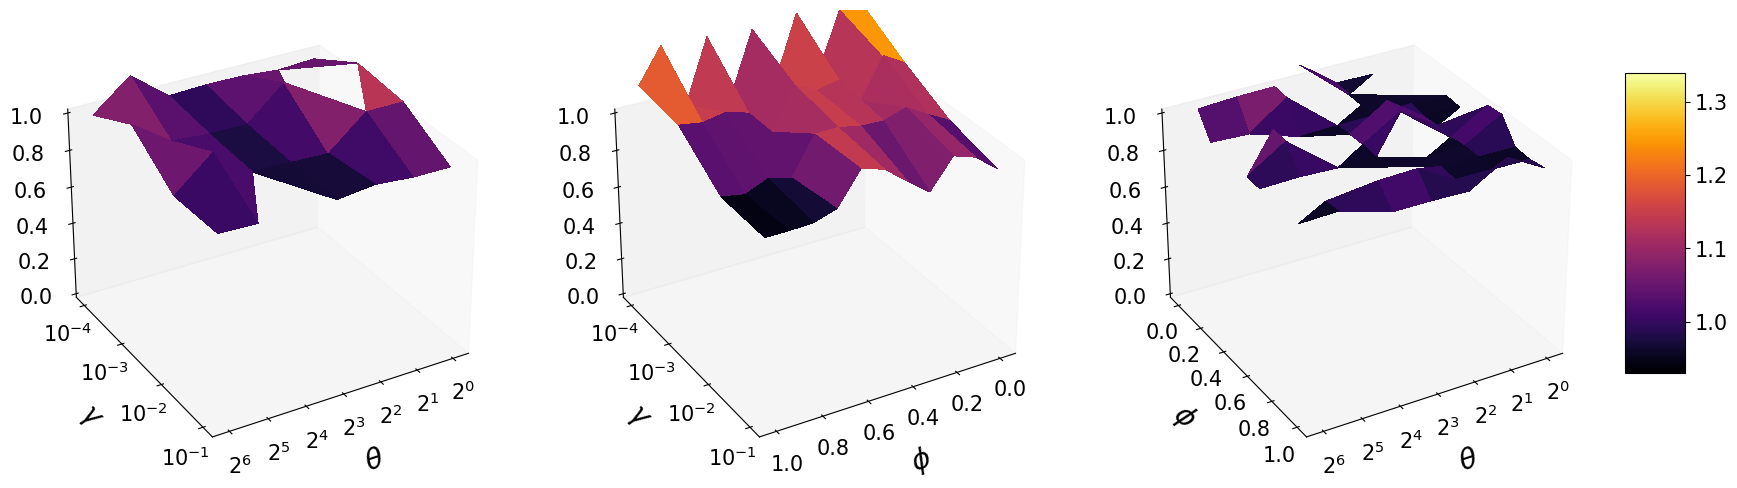

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [ ]:
data = read_data(RES_DIR, folders=["strategies_5runs"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:3.849e-01 t=-9.206e-01
random vs. misinformation: Welch's t-test independent samples, P_val:6.052e-01 t=-5.383e-01
random vs. liberal: Welch's t-test independent samples, P_val:3.049e-01 t=-1.118e+00
random vs. conservative: Welch's t-test independent samples, P_val:3.251e-02 t=-2.658e+00


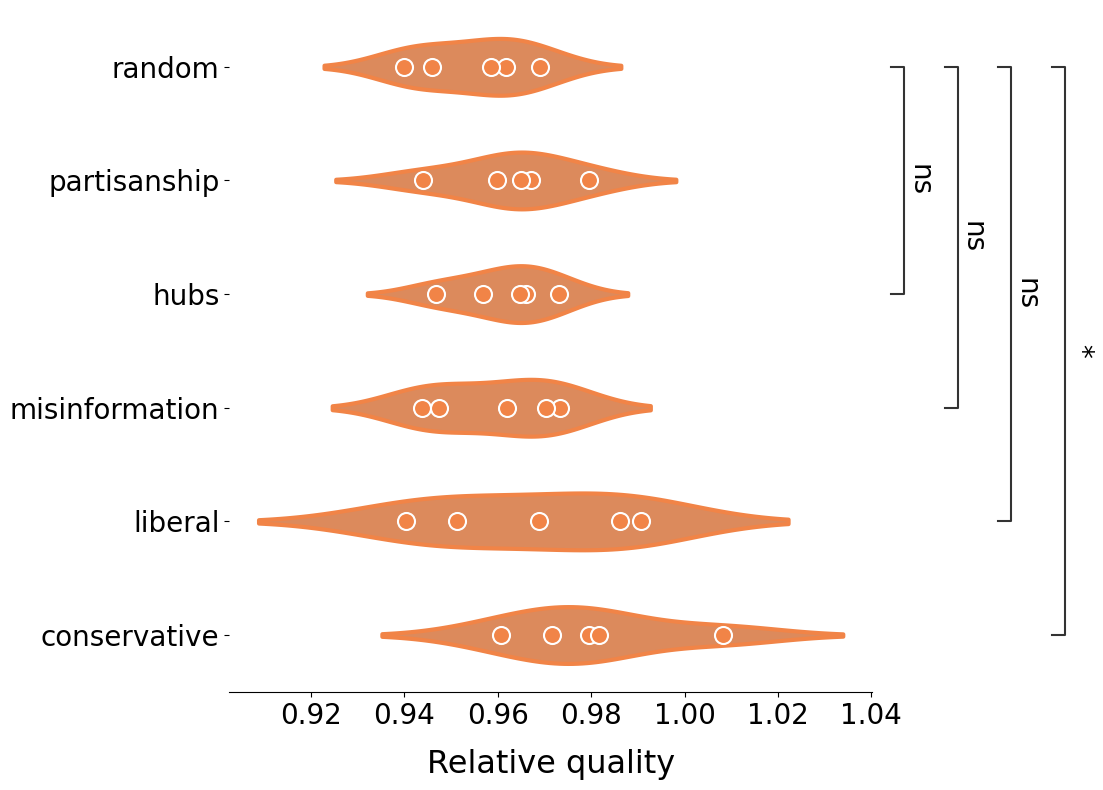

In [ ]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()